# Fusing Depth Data

## Overview

Most cryptocurrency exchanges do not deliver true tick-by-tick Level-2 data. Instead, they provide conflated feeds in which individual order-book updates are aggregated over short intervals. For example, Binance Futures’ `depth@0ms` stream is still aggregated: You can confirm that its best-bid-offer (BBO) values update less frequently than those in the `bookTicker` stream, which captures every BBO change. Other venues state similar limitations explicitly—Bybit, for instance, publishes the Level 1 data (BBO) every 10ms, the Level 50 data every 20ms, and the Level 200 data every 100ms.

To generate accurate fill simulations and realistic backtesting results, you must therefore fuse multiple depth streams into a single feed that preserves the highest possible update frequency and granularity.

Let’s see Binance Futures as our example.

## Data Preparation

In [1]:
!wget https://datasets.tardis.dev/v1/binance-futures/trades/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_trades_20250501.csv.gz
!wget https://datasets.tardis.dev/v1/binance-futures/incremental_book_L2/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_incremental_book_L2_20250501.csv.gz
!wget https://datasets.tardis.dev/v1/binance-futures/book_ticker/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_book_ticker_20250501.csv.gz

In [2]:
from hftbacktest.data.utils import tardis

tardis.convert(
    [
        'BTCUSDT_incremental_book_L2_20250501.csv.gz',
        'BTCUSDT_trades_20250501.csv.gz'
    ],
    output_filename='BTCUSDT_20250501.npz',
    buffer_size=1_000_000_000,
    snapshot_mode='process'
)

Reading BTCUSDT_incremental_book_L2_20250501.csv.gz
Reading BTCUSDT_trades_20250501.csv.gz
Correcting the latency
Correcting the event order
Saving to BTCUSDT_20250501.npz


array([(3758096386, 1746057600043000000, 1746057600046245000, 94125.2, 1.0000e-02, 0, 0, 0.),
       (3758096387, 1746057600072000000, 1746057601025373000, 93954.8, 0.0000e+00, 0, 0, 0.),
       (3758096388, 1746057600072000000, 1746057601025373000, 94125.1, 1.0798e+01, 0, 0, 0.),
       ...,
       (3758096385, 1746143999978000000, 1746143999980195000, 96406. , 1.5590e+00, 0, 0, 0.),
       (3758096385, 1746143999978000000, 1746143999980195000, 96411.2, 6.1000e-02, 0, 0, 0.),
       (3758096385, 1746143999978000000, 1746143999980195000, 96423.2, 1.0130e+01, 0, 0, 0.)],
      dtype={'names': ['ev', 'exch_ts', 'local_ts', 'px', 'qty', 'order_id', 'ival', 'fval'], 'formats': ['<u8', '<i8', '<i8', '<f8', '<f8', '<u8', '<i8', '<f8'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64, 'aligned': True})

Use the backtester to replay the data, get the BBO values from the Level-2 depth feed to compare it with the BBO obtained from the book ticker stream.

In [3]:
import numpy as np
from numba import njit
from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest
)

@njit
def record_l2_bbo(
    hbt,
    timeout
):
    asset_no = 0
    t = 0
    l2_bbo = np.full((30_000_000, 5), np.nan, np.float64)
    prev_best_bid = np.nan
    prev_best_ask = np.nan
    prev_best_bid_qty = np.nan
    prev_best_ask_qty = np.nan

    # 0: Timeout(no market feed received within the timeout interval)
    # 2: Market Feed
    # Otherwise, an error occurs.
    while hbt.wait_next_feed(False, timeout) in [0, 2]: 
        depth = hbt.depth(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        best_bid_qty = depth.bid_qty_at_tick(depth.best_bid_tick)
        best_ask_qty = depth.ask_qty_at_tick(depth.best_ask_tick)
        
        if (
            best_bid != prev_best_bid 
            or best_ask != prev_best_ask
            or best_bid_qty != prev_best_bid_qty
            or best_ask_qty != prev_best_ask_qty
        ):
            l2_bbo[t, 0] = hbt.current_timestamp
            l2_bbo[t, 1] = prev_best_bid = best_bid
            l2_bbo[t, 2] = prev_best_ask = best_ask
            l2_bbo[t, 3] = prev_best_bid_qty = best_bid_qty
            l2_bbo[t, 4] = prev_best_ask_qty = best_ask_qty
        
            t += 1
        
            if t >= len(l2_bbo):
                raise Exception

    return l2_bbo[:t]

In [4]:
%%time

roi_lb = 50000
roi_ub = 150000

asset = (
    BacktestAsset()
        .data(['BTCUSDT_20250501.npz'])
        .linear_asset(1.0) 
        .constant_order_latency(0, 0)
        .power_prob_queue_model(2)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

timeout = 100_000_000 # 100ms

l2_bbo = record_l2_bbo(
    hbt,
    timeout
)

_ = hbt.close()

CPU times: user 38.7 s, sys: 1.75 s, total: 40.4 s
Wall time: 40.4 s


## Comparing BBO updates: Level-2 (depth@0ms) Stream vs bookTicker Stream

The `bookTicker` stream delivers updates more often and leads the Level-2 feed by a small margin.

In [5]:
import polars as pl
from matplotlib import pyplot as plt

In [6]:
df_l2_bbo = pl.DataFrame(l2_bbo)
df_l2_bbo.columns = ['Local Timestamp', 'Bid', 'Ask', 'Bid Qty', 'Ask Qty']

df_l2_bbo = df_l2_bbo.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='ns')
).filter(
    (pl.col('Local Timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('Local Timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

In [7]:
df_book_ticker = pl.read_csv('BTCUSDT_book_ticker_20250501.csv.gz').with_columns(
    pl.from_epoch('local_timestamp', time_unit='us')
).select(
    'local_timestamp', 'bid_price', 'ask_price', 'bid_amount', 'ask_amount'
).filter(
    (pl.col('local_timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('local_timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

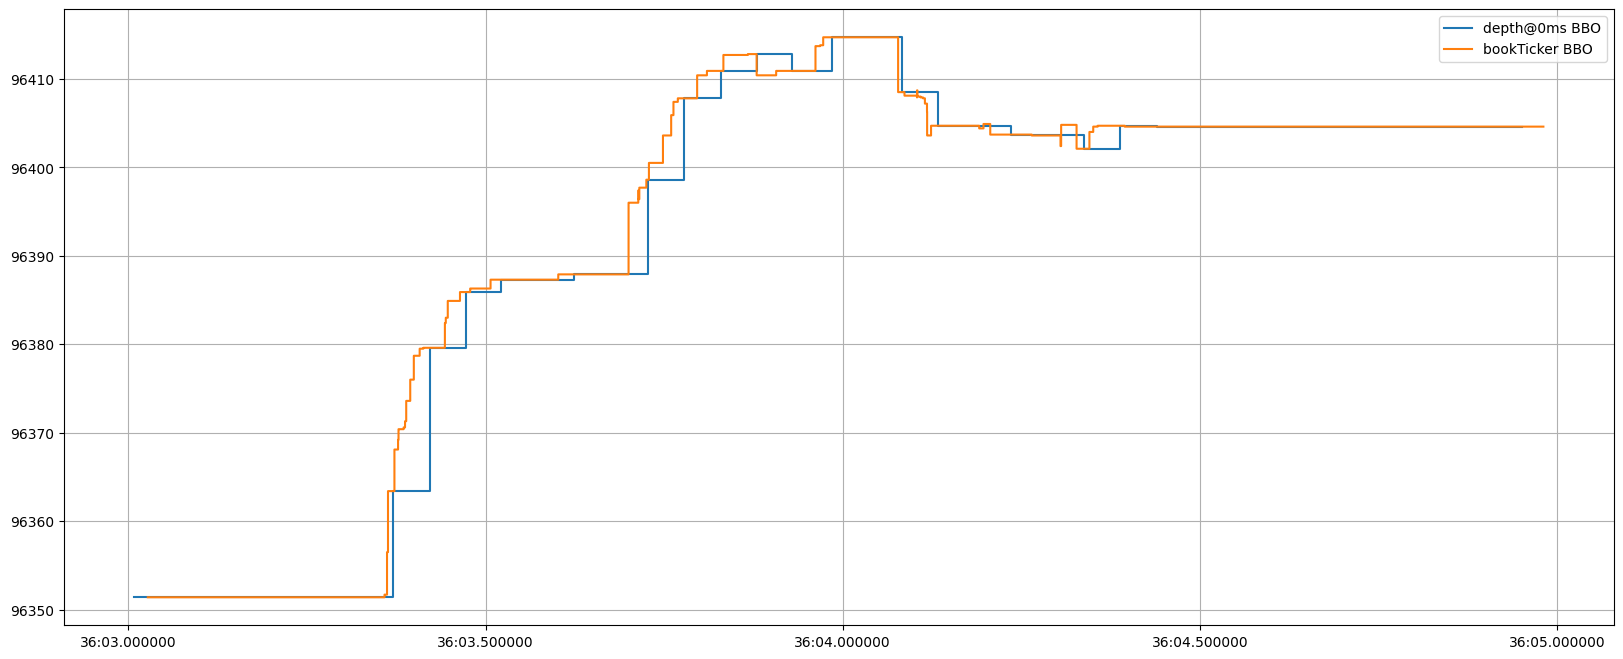

In [8]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Bid'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['bid_price'], where='post')
plt.legend(['depth@0ms BBO', 'bookTicker BBO'])
plt.grid()

You’ll notice that the `bookTicker` stream delivers updates far more frequently—especially when you factor in changes to both price and quantity.

In [9]:
with pl.Config(tbl_rows=100):
    print(df_l2_bbo)

shape: (39, 5)
┌───────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ Local Timestamp               ┆ Bid     ┆ Ask     ┆ Bid Qty ┆ Ask Qty │
│ ---                           ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ datetime[ns]                  ┆ f64     ┆ f64     ┆ f64     ┆ f64     │
╞═══════════════════════════════╪═════════╪═════════╪═════════╪═════════╡
│ 2025-05-01 14:36:03.008176128 ┆ 96351.4 ┆ 96351.5 ┆ 6.344   ┆ 7.159   │
│ 2025-05-01 14:36:03.060811008 ┆ 96351.4 ┆ 96351.5 ┆ 6.368   ┆ 1.297   │
│ 2025-05-01 14:36:03.112276992 ┆ 96351.4 ┆ 96351.5 ┆ 6.528   ┆ 0.128   │
│ 2025-05-01 14:36:03.163234048 ┆ 96351.4 ┆ 96351.5 ┆ 6.878   ┆ 0.188   │
│ 2025-05-01 14:36:03.215074048 ┆ 96351.4 ┆ 96351.5 ┆ 6.584   ┆ 2.819   │
│ 2025-05-01 14:36:03.266274048 ┆ 96351.4 ┆ 96351.5 ┆ 6.399   ┆ 1.996   │
│ 2025-05-01 14:36:03.316154112 ┆ 96351.4 ┆ 96351.5 ┆ 6.399   ┆ 2.127   │
│ 2025-05-01 14:36:03.369733888 ┆ 96363.4 ┆ 96380.3 ┆ 1.12    ┆ 0.006   │
│ 2025-05-01 14:36:03.4

In [10]:
with pl.Config(tbl_rows=100):
    print(df_book_ticker)

shape: (1_432, 5)
┌────────────────────────────┬───────────┬───────────┬────────────┬────────────┐
│ local_timestamp            ┆ bid_price ┆ ask_price ┆ bid_amount ┆ ask_amount │
│ ---                        ┆ ---       ┆ ---       ┆ ---        ┆ ---        │
│ datetime[μs]               ┆ f64       ┆ f64       ┆ f64        ┆ f64        │
╞════════════════════════════╪═══════════╪═══════════╪════════════╪════════════╡
│ 2025-05-01 14:36:03.027063 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.157      │
│ 2025-05-01 14:36:03.027070 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.154      │
│ 2025-05-01 14:36:03.027072 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.121      │
│ 2025-05-01 14:36:03.029315 ┆ 96351.4   ┆ 96351.5   ┆ 6.35       ┆ 7.121      │
│ 2025-05-01 14:36:03.030317 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.121      │
│ 2025-05-01 14:36:03.045954 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.119      │
│ 2025-05-01 14:36:03.049547 ┆ 96351.4   ┆ 96351.5   ┆ 6.348      ┆ 7.119      │
│ 2025-05-

This tutorial will demonstrate how to merge multiple depth-update streams into a single, high-frequency, fine-grained feed—and show how this fused data improves backtesting results. (to be continued...)